In [1]:
import torch
from torch.nn import functional as F
from torch import nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from pathlib import Path
import random
from PIL import Image
import seaborn as sns
import pandas as pd
from torchinfo import summary

In [2]:
image_path = Path('data/cat_dog')
for dirpath, dirnames, filenames in os.walk(image_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} file in {dirpath}')

There are 2 directories and 0 file in data\cat_dog
There are 2 directories and 0 file in data\cat_dog\test
There are 0 directories and 2500 file in data\cat_dog\test\cat
There are 0 directories and 2500 file in data\cat_dog\test\dog
There are 2 directories and 0 file in data\cat_dog\train
There are 0 directories and 10000 file in data\cat_dog\train\cat
There are 0 directories and 10000 file in data\cat_dog\train\dog


cat


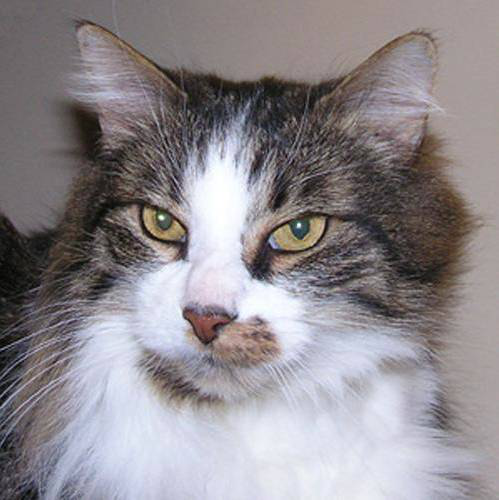

In [3]:
imagelist = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(imagelist)
print(random_image_path.stem[:3])
Image.open(random_image_path)

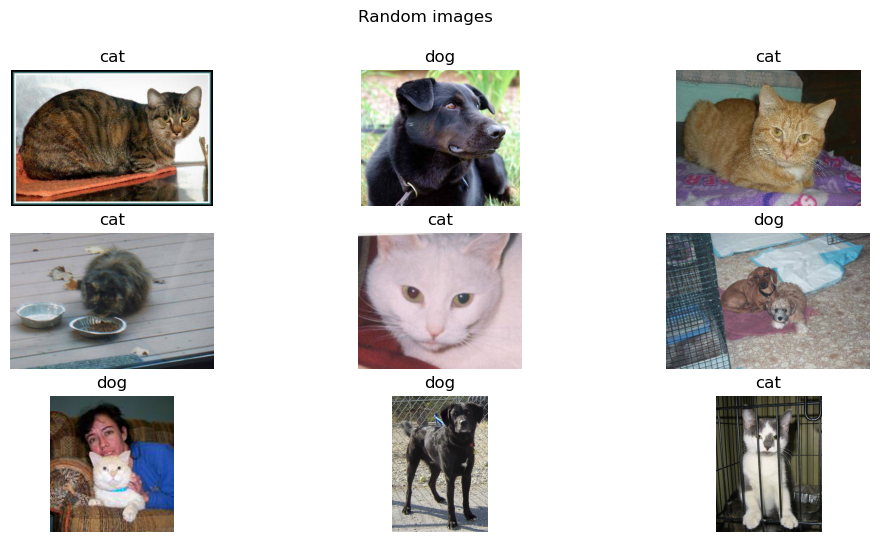

In [161]:
n_rows = 3
n_cols = 3
fig = plt.figure(figsize=(12, 6))

for i in range(1, n_rows*n_cols+1):
    rand_img_path = random.choice(imagelist)
    fig.add_subplot(n_rows, n_cols, i)
    plt.imshow(plt.imread(rand_img_path))
    plt.title(rand_img_path.stem[:3])
    plt.axis(False)
    plt.suptitle('Random images')

plt.show()

In [5]:
for i in range(10):
    idx = random.randint(0, len(imagelist))
    dim1, dim2, shape = plt.imread(imagelist[idx]).shape
    print(f'Looking at idx {idx}: dim1={dim1}, dim2={dim2}, shape={shape}')

Looking at idx 899: dim1=374, dim2=500, shape=3
Looking at idx 15274: dim1=165, dim2=225, shape=3
Looking at idx 21876: dim1=480, dim2=432, shape=3
Looking at idx 9726: dim1=180, dim2=360, shape=3
Looking at idx 13239: dim1=500, dim2=431, shape=3
Looking at idx 18634: dim1=488, dim2=500, shape=3
Looking at idx 16490: dim1=269, dim2=167, shape=3
Looking at idx 6994: dim1=375, dim2=499, shape=3
Looking at idx 23936: dim1=269, dim2=360, shape=3
Looking at idx 2551: dim1=253, dim2=117, shape=3


In [6]:
# Dimensions for the images are rough, finding the average dimension that would be suitable to train the model on
# dim1 = []
# dim2 = []

# for i in range(len(imagelist)):
#     d1, d2, col = plt.imread(imagelist[i]).shape
#     dim1.append(d1)
#     dim2.append(d2)
#     if (i+1) % 5000 == 0:
#         print(f'Passed number {i}')
# dim1_mean, dim2_mean = round(torch.mean(torch.tensor(dim1), dtype=torch.float32).item()), round(torch.mean(torch.tensor(dim2), dtype=torch.float32).item())
# len(dim1), len(dim2)

In [7]:
dim1_mean, dim2_mean = (360, 404)
dim1_mean, dim2_mean

(360, 404)

In [8]:
# sns.jointplot(x=dim1, y=dim2)

In [9]:
dim1_mean, dim2_mean = dim1_mean//8, dim2_mean//8

cus_transfrom = transforms.Compose([
    transforms.Resize(size=[dim1_mean, dim2_mean]),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

(-0.5, 49.5, 44.5, -0.5)

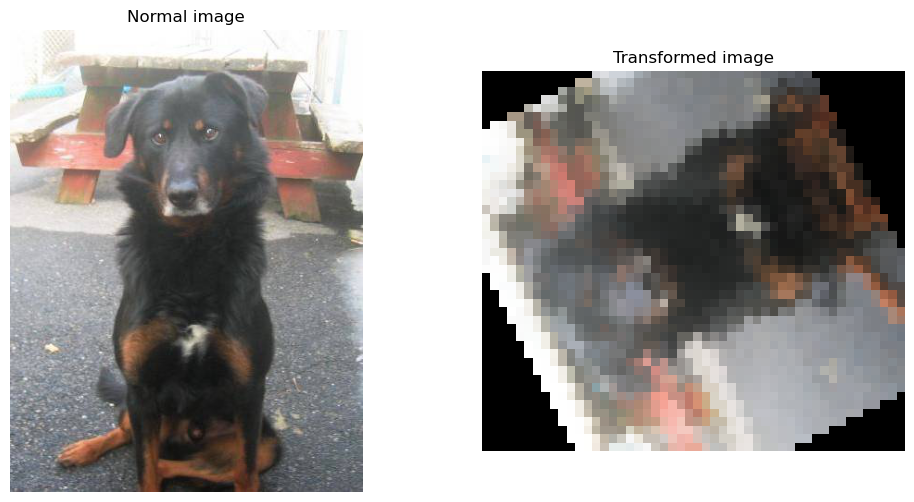

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
image = imagelist[random.randint(0, len(imagelist))]
transformed_image = cus_transfrom(Image.open(image))
ax[0].imshow(plt.imread(image))
ax[0].set_title('Normal image')
ax[0].axis(False)
ax[1].imshow(transformed_image.permute(1,2,0))
ax[1].set_title('Transformed image')
ax[1].axis(False)

## Building the dataset

### Moving images to appropriate folder

In [11]:
# catpath = Path('data/cat')
# dogpath = Path('data/dog')
# train_path = Path('data/cat_dog/train')
# test_path = Path('data/cat_dog/test')
# train_path.mkdir(exist_ok=True, parents=True)
# test_path.mkdir(exist_ok=True, parents=True)

# catslist = list(catpath.glob('*.jpg'))
# dogslist = list(dogpath.glob('*.jpg'))
# print(len(catslist), len(dogslist))
# test_split = int(len(catslist) * 0.2)
# print(test_split)

In [12]:
# rand_sel_cat = random.sample(catslist, k=test_split)
# rand_sel_dog = random.sample(dogslist, k=test_split)
# # print(rand_sel)
# # print(rand_sel)
# for img_cat, img_dog in zip(rand_sel_cat, rand_sel_dog):
#     img_cat = img_cat
#     img_dog = img_dog
#     img_cat_name = img_cat.name
#     img_dog_name = img_dog.name
#     cat_target = test_path / 'cat'
#     dog_target = test_path / 'dog'
#     cat_target.mkdir(exist_ok=True, parents=True)
#     dog_target.mkdir(exist_ok=True, parents=True)
#     img_cat.rename(cat_target / img_cat_name)
#     img_dog.rename(dog_target / img_dog_name)

In [13]:
# catslist = list(catpath.glob('*.jpg'))
# dogslist = list(dogpath.glob('*.jpg'))

# for img_cat, img_dog in zip(catslist, dogslist):
#     img_cat = img_cat
#     img_dog = img_dog
#     img_cat_name = img_cat.name
#     img_dog_name = img_dog.name
#     cat_target = train_path / 'cat'
#     dog_target = train_path / 'dog'
#     cat_target.mkdir(exist_ok=True, parents=True)
#     dog_target.mkdir(exist_ok=True, parents=True)
#     img_cat.rename(cat_target / img_cat_name)
#     img_dog.rename(dog_target / img_dog_name)

In [14]:
# df = pd.read_csv('data/cat_dog.csv')
# df.head(10)

## setting up

In [15]:
trainpath = Path('data/cat_dog/train/')
testpath = Path('data/cat_dog/test/')

def get_classes(path: Path):
    classes = [folder.name for folder in os.scandir(path) if folder.is_dir()]
    classes_to_idx = {k:v for v, k in enumerate(classes)}
    return classes, classes_to_idx
get_classes(trainpath)

(['cat', 'dog'], {'cat': 0, 'dog': 1})

In [16]:
class ImageDataset(Dataset):
    def __init__(self, target_dir: str, transform: torchvision.transforms = None):
        super().__init__()
        self.paths = list(Path(target_dir).glob('*/*.jpg'))
        self.transform = transform
        self.classes, self.classes_to_idx = get_classes(target_dir)

    def load_image(self, idx):
        return Image.open(self.paths[idx])

    def __getitem__(self, idx):
        img = self.load_image(idx)
        class_name = self.paths[idx].parent.name
        class_idx = self.classes_to_idx[class_name]
        if self.transform:
            img = self.transform(img)
        return img, class_idx

    def __len__(self):
        return len(self.paths)

In [17]:
train_transforms = transforms.Compose([
    transforms.Resize(size=[dim1_mean, dim2_mean]),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=[dim1_mean, dim2_mean]),
    transforms.ToTensor()
])

In [18]:
train_dataset = ImageDataset(trainpath, transform=train_transforms)
test_dataset = ImageDataset(testpath, transform=test_transforms)

len(train_dataset), len(test_dataset)

(20000, 5000)

In [19]:
train_dataset.classes

['cat', 'dog']

In [20]:
train_dataset.classes_to_idx

{'cat': 0, 'dog': 1}

torch.Size([3, 45, 50])


(<matplotlib.image.AxesImage at 0x16ea3ac5510>, 0)

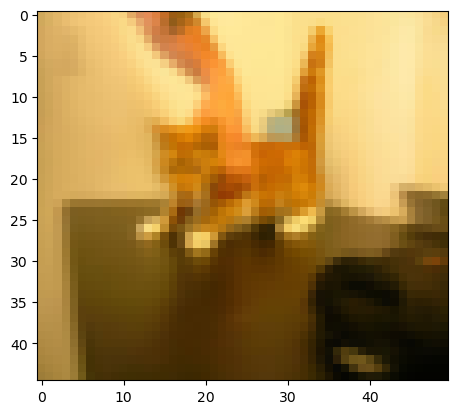

In [21]:
img = next(iter(train_dataset))
print(img[0].shape)
plt.imshow(img[0].permute(1,2,0)), img[1]

torch.Size([3, 45, 50])


(<matplotlib.image.AxesImage at 0x16ea3ba1630>, 0)

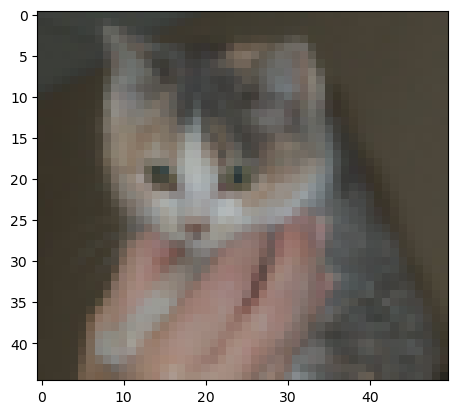

In [22]:
img = next(iter(test_dataset))
print(img[0].shape)
plt.imshow(img[0].permute(1,2,0)), img[1]

# Dataloaders

In [23]:
os.cpu_count()

4

In [30]:
batch = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch)

len(train_dataloader), len(test_dataloader)

(625, 157)

# The model

In [55]:
class ModelV0(nn.Module):
    def __init__(self, input_features: int, hidden_units: int, output_features: int):
        super().__init__()
        self.block_one = nn.Sequential(
            nn.Conv2d(in_channels=input_features, out_channels=hidden_units, kernel_size=[4,4], stride=[1,1], padding=[1,1]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=[2,2], stride=[2,2]),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=[4,4], stride=[1,1], padding=[1,1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[2,2], stride=[2,2]),
            nn.ReLU(),
        )
        self.block_two = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=[4,4], stride=[1,1], padding=[1,1]),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=[2,2], stride=[2,2]),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=[4,4], stride=[1,1], padding=[1,1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[2,2], stride=[2,2]),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*9*11, out_features=output_features)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x = self.block_one(x)
        # print(x.shape)
        # x = self.block_two(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        # return x
        return self.classifier(self.block_two(self.block_one(x)))

model_0 = ModelV0(input_features=3, hidden_units=10, output_features=1)
summary(model_0, input_size=[1, 3, dim1_mean, dim2_mean], device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
ModelV0                                  [1, 1]                    --
├─Sequential: 1-1                        [1, 10, 21, 24]           --
│    └─Conv2d: 2-1                       [1, 10, 44, 49]           490
│    └─ReLU: 2-2                         [1, 10, 44, 49]           --
│    └─Conv2d: 2-3                       [1, 10, 43, 48]           1,610
│    └─ReLU: 2-4                         [1, 10, 43, 48]           --
│    └─MaxPool2d: 2-5                    [1, 10, 21, 24]           --
│    └─ReLU: 2-6                         [1, 10, 21, 24]           --
├─Sequential: 1-2                        [1, 10, 9, 11]            --
│    └─Conv2d: 2-7                       [1, 10, 20, 23]           1,610
│    └─ReLU: 2-8                         [1, 10, 20, 23]           --
│    └─Conv2d: 2-9                       [1, 10, 19, 22]           1,610
│    └─ReLU: 2-10                        [1, 10, 19, 22]           --
│    

In [56]:
rand_img = torch.rand(size=[1, 3, dim1_mean, dim2_mean])
model_0.eval()
with torch.inference_mode():
    logits = model_0(rand_img)
logits.sigmoid().round()

tensor([[1.]])

## Optimizers and loss functions

In [57]:
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=1e-3)
criteron = nn.BCEWithLogitsLoss()

## Train and test loops

In [60]:
epochs = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)

def train_model(model: torch.nn.Module, epochs: int, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader, criteron: torch.nn.Module, optimizer: torch.optim.Optimizer):
    model.to(device)
    for epoch in range(epochs):
        print('starting...')
        train_loss, test_loss, train_acc, test_acc = 0, 0, 0, 0
        model.train()
        for X, y in train_dataloader:
            X, y = X.to(device), y.type(torch.float32).to(device)
            logits = model(X).squeeze()
            preds = logits.sigmoid().round()
            loss = criteron(logits, y)
            train_loss += loss.item()
            train_acc += torch.eq(preds, y).sum().item() / len(y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc = train_acc / len(train_dataloader)
        train_loss = train_loss / len(train_dataloader)
        # Testing
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.type(torch.float32).to(device)
                logits = model(X).squeeze()
                preds = logits.sigmoid().round().type(torch.int64)
                loss = criteron(logits, y)
                test_loss += loss.item()
                test_acc += torch.eq(preds, y).sum().item() / len(y)
            test_acc = test_acc / len(test_dataloader)
            test_loss = test_loss / len(test_dataloader)
        print(f'EPOCH {epoch+1} || train loss: {train_loss:.4f} | train acc: {int(train_acc * 100):.2f}% || test loss: {test_loss:.4f} | test acc: {int(test_acc * 100):.2f}%')

train_model(model_0, epochs, train_dataloader, test_dataloader, criteron, optimizer)

starting...
EPOCH 1 || train loss: 0.5089 | train acc: 74.00% || test loss: 0.4330 | test acc: 79.00%
starting...
EPOCH 2 || train loss: 0.5152 | train acc: 74.00% || test loss: 0.4236 | test acc: 80.00%
starting...
EPOCH 3 || train loss: 0.5065 | train acc: 74.00% || test loss: 0.4185 | test acc: 81.00%
starting...
EPOCH 4 || train loss: 0.5094 | train acc: 74.00% || test loss: 0.4163 | test acc: 80.00%
starting...
EPOCH 5 || train loss: 0.5046 | train acc: 74.00% || test loss: 0.4123 | test acc: 81.00%
starting...
EPOCH 6 || train loss: 0.5054 | train acc: 74.00% || test loss: 0.4539 | test acc: 78.00%
starting...
EPOCH 7 || train loss: 0.5008 | train acc: 74.00% || test loss: 0.4280 | test acc: 80.00%
starting...
EPOCH 8 || train loss: 0.5049 | train acc: 74.00% || test loss: 0.4214 | test acc: 80.00%
starting...
EPOCH 9 || train loss: 0.5012 | train acc: 74.00% || test loss: 0.4231 | test acc: 80.00%
starting...
EPOCH 10 || train loss: 0.4944 | train acc: 75.00% || test loss: 0.413

In [63]:
model_0.state_dict

<bound method Module.state_dict of ModelV0(
  (block_one): Sequential(
    (0): Conv2d(3, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (block_two): Sequential(
    (0): Conv2d(10, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=990, out_features=1, bias=True)
  )
)>

In [70]:
train_dataset.classes_to_idx.values()

dict_values([0, 1])

Predicted class: dog, true class: cat


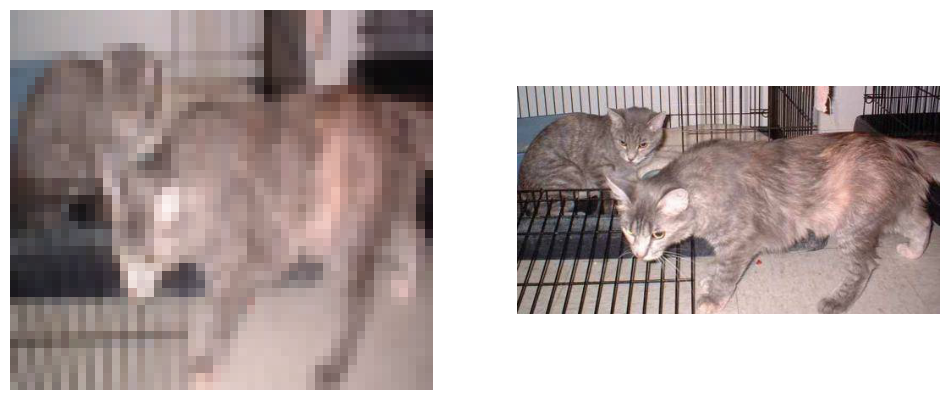

In [130]:
def make_predictions(model, transforms, image, device, class_to_idx):
    model.to(device)
    image_path = image
    image = Image.open(image)
    trans_image = transforms(image).unsqueeze(dim=0).to(device)
    logits = model(trans_image)
    preds = int(logits.sigmoid().round())
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].imshow(trans_image.squeeze(dim=0).cpu().permute(1,2,0))
    ax[0].axis(False)
    ax[1].imshow(plt.imread(image_path))
    ax[1].axis(False)
    class_name = [(k, v) for k, v in class_to_idx.items() if v == preds][0][0]
    return class_name

testlist = list(testpath.glob('*/*.jpg'))
rand_path = random.choice(testlist)
true_class = rand_path.parent.name
predicted_class = make_predictions(model_0, test_transforms, rand_path, device, train_dataset.classes_to_idx)
print(f'Predicted class: {predicted_class}, true class: {true_class}')

In [127]:
# testlist = list(testpath.glob('*/*.jpg'))
# rand_path = random.choice(testlist)
# make_predictions(model_0, test_transforms, rand_path, device, train_dataset.classes_to_idx)

In [158]:
MODEL_SAVE_PATH = Path('models')
MODEL_SAVE_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = 'ModelV0.pth'
model_attributes = {'input_features': 3, 'hidden_features': 10, 'output_features': 1}
model_obj = {'model_attributes': model_attributes, 'transform': test_transforms, 'model_weights': model_0.state_dict(), 'classes': train_dataset.classes, 'classes_to_idx': train_dataset.classes_to_idx}
torch.save(model_obj, MODEL_SAVE_PATH/MODEL_NAME)

In [159]:
loaded_data = torch.load(MODEL_SAVE_PATH/MODEL_NAME)
loaded_model = loaded_data['model_instance']
loaded_model.load_state_dict(loaded_data['model_weights'])

<All keys matched successfully>

Predicted class: cat, true class: cat


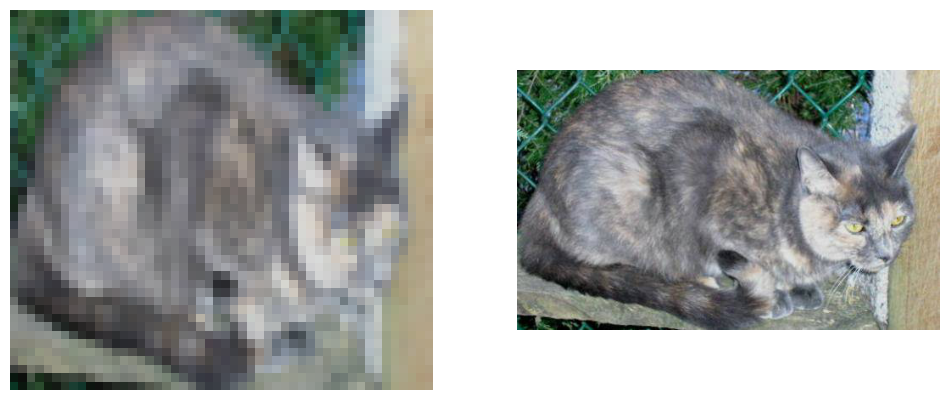

In [160]:
testlist = list(testpath.glob('*/*.jpg'))
rand_path = random.choice(testlist)
true_class = rand_path.parent.name
predicted_class = make_predictions(loaded_model, loaded_data['transform'], rand_path, device, loaded_data['classes_to_idx'])
print(f'Predicted class: {predicted_class}, true class: {true_class}')